In [7]:
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.fixes import np_version
!pip install numpy==1.25.0
!pip install scipy==1.10.1
!pip install scikit-learn==1.3.2
!pip install shap==0.44.0



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


^C



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


^C



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import numpy as np

In [24]:
print(np.__version__)

1.26.4


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, roc_auc_score, RocCurveDisplay)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
import joblib
import shap
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings("ignore")

In [68]:
df = pd.read_csv("1. exploring_datasets/diabetes_datasets/diabetis_prediction_dataset/diabetes_prediction_dataset.csv")
df.head()


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


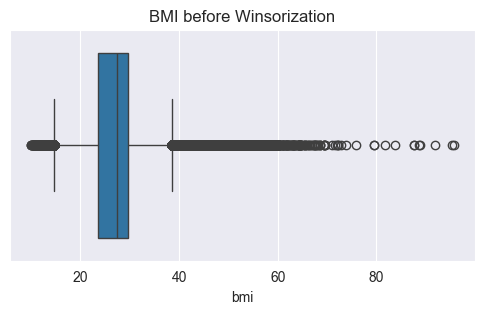

In [69]:
# 1.0 Visualize BMI before Winsorization
plt.figure(figsize=(6, 3))
sns.boxplot(x=df["bmi"])
plt.title("BMI before Winsorization")
plt.show()

In [70]:
# 1.1 Handle BMI outliers with Winsorization
from scipy.stats.mstats import winsorize
df["bmi"] = winsorize(df["bmi"], limits=[0.01, 0.01])

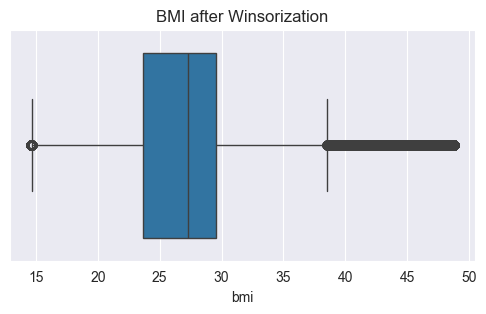

In [71]:
plt.figure(figsize=(6, 3))
sns.boxplot(x=df["bmi"])
plt.title("BMI after Winsorization")
plt.show()

In [72]:
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

In [73]:
# 2. Feature separation
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

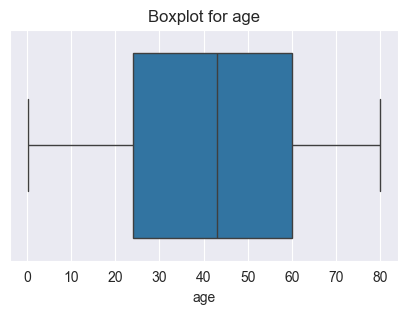

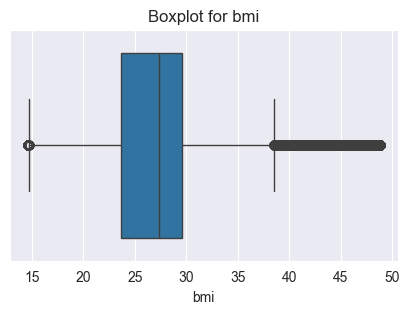

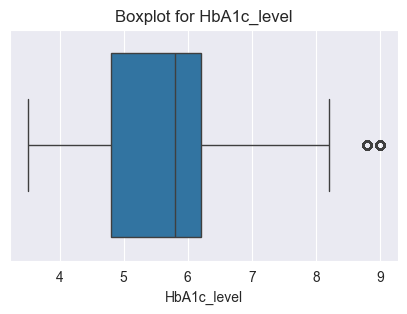

In [74]:
# 3. Outlier detection via boxplot
for col in ["age", "bmi", "HbA1c_level"]:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

In [75]:
# 4. Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", StandardScaler(), numerical_cols)
])

In [76]:
# 5. Preprocess data for SMOTE
X_preprocessed = preprocessor.fit_transform(X)

In [77]:
# 6. Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

In [78]:
# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, stratify=y_resampled, test_size=0.2, random_state=42
)

In [79]:
# 8. Grid Search for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'class_weight': [None, 'balanced']
}

gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring="recall", n_jobs=-1)
gs_rf.fit(X_train, y_train)
print("Best Parameters:", gs_rf.best_params_)

Best Parameters: {'class_weight': None, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [80]:
# 9. Feature selection
sel_model = SelectFromModel(gs_rf.best_estimator_, prefit=True)
X_train_sel = sel_model.transform(X_train)
X_test_sel = sel_model.transform(X_test)

In [81]:
# 10. Final RF training on selected features
rf = RandomForestClassifier(**gs_rf.best_params_, random_state=42)
rf.fit(X_train_sel, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [43]:
# 11. Logistic Regression for comparison
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_sel, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [82]:
# 12. Evaluation function
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc = roc_auc_score(y_test, y_scores)
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=name).plot()
        plt.title(f"ROC Curve - {name}")
        plt.show()


=== Random Forest (Optimized) ===
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     18300
           1       0.98      0.97      0.97     18300

    accuracy                           0.97     36600
   macro avg       0.97      0.97      0.97     36600
weighted avg       0.97      0.97      0.97     36600



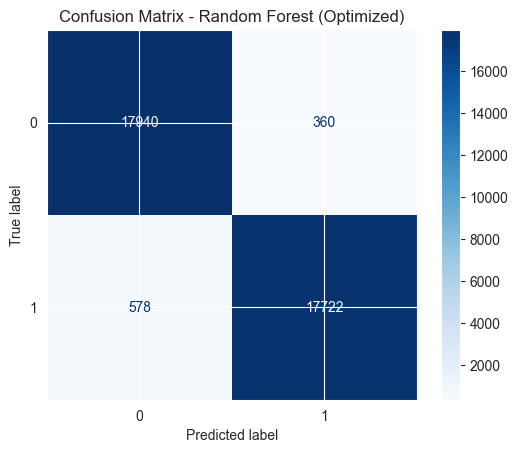

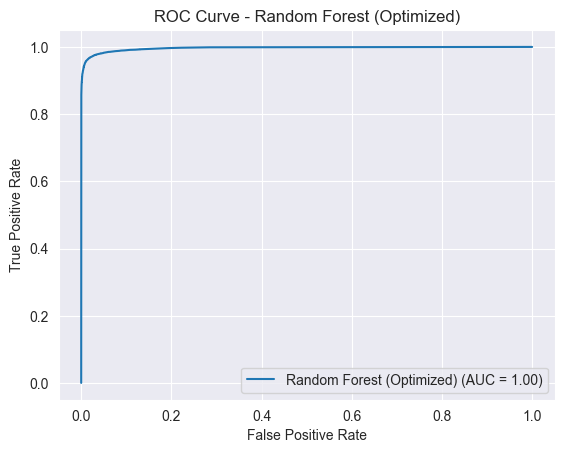


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     18300
           1       0.88      0.88      0.88     18300

    accuracy                           0.88     36600
   macro avg       0.88      0.88      0.88     36600
weighted avg       0.88      0.88      0.88     36600



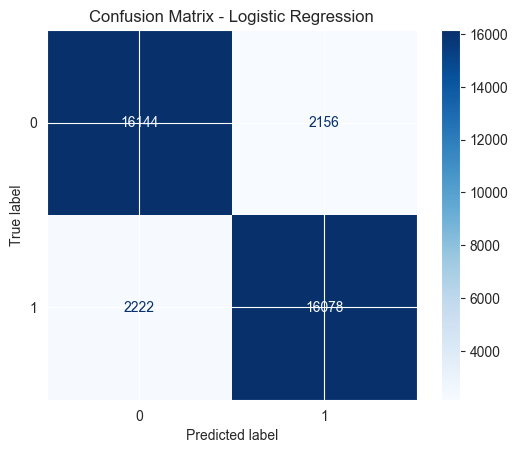

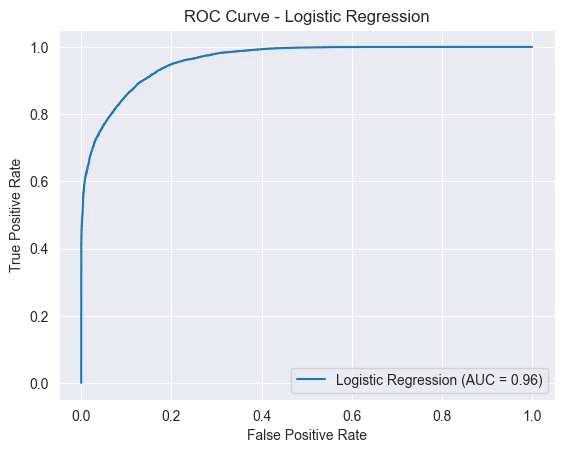

In [83]:
# 13. Evaluate both models
evaluate_model(rf, X_test_sel, y_test, name="Random Forest (Optimized)")
evaluate_model(logreg, X_test_sel, y_test, name="Logistic Regression")

 98%|===================| 392/400 [00:30<00:00]        

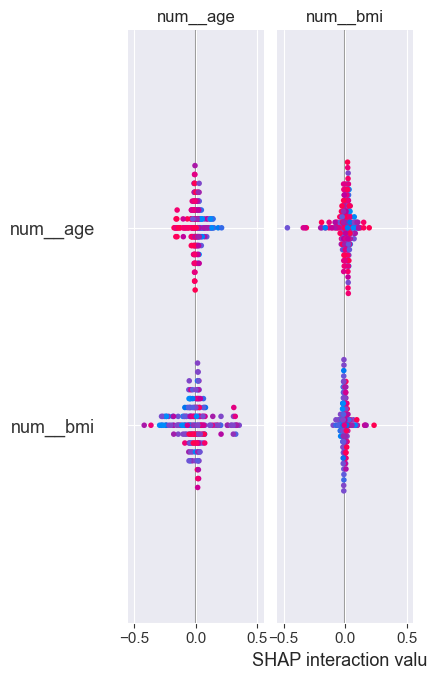

In [91]:
# 14. SHAP explanation
all_features = preprocessor.get_feature_names_out()
selected_mask = sel_model.get_support()
selected_features = all_features[selected_mask]

X_train_sel_df = pd.DataFrame(X_train_sel, columns=selected_features)
X_test_sel_df = pd.DataFrame(X_test_sel, columns=selected_features)


explainer = shap.Explainer(rf, X_train_sel_df[:500])
shap_values = explainer(X_test_sel_df[:200], check_additivity=False)

shap.summary_plot(shap_values, X_test_sel_df[:200], feature_names=np.array(selected_features))



In [93]:
print(shap_values.shape)

(200, 4, 2)


In [94]:
type(shap_values)

shap._explanation.Explanation

In [95]:
print(shap_values.shape)
print(shap_values[0])

(200, 4, 2)
.values =
array([[ 0.07173469, -0.07173469],
       [ 0.04087816, -0.04087816],
       [ 0.18286292, -0.18286291],
       [ 0.17119048, -0.17119048]])

.base_values =
array([0.4778191, 0.5221809])

.data =
array([ 0.22712644, -0.23430838,  0.62810674, -0.2962091 ])


In [96]:
print(shap_values[0].data.shape)
print(shap_values[0].feature_names)

(4,)
['num__age', 'num__bmi', 'num__HbA1c_level', 'num__blood_glucose_level']


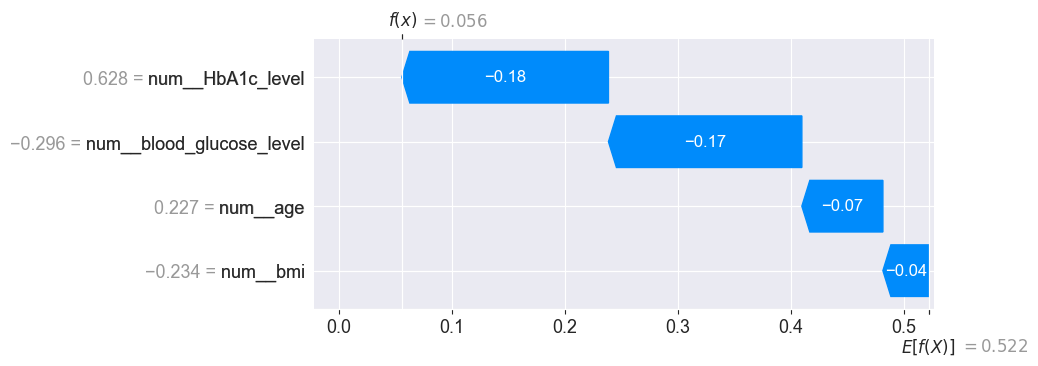

In [97]:
shap.plots.waterfall(shap_values[0][:, 1])

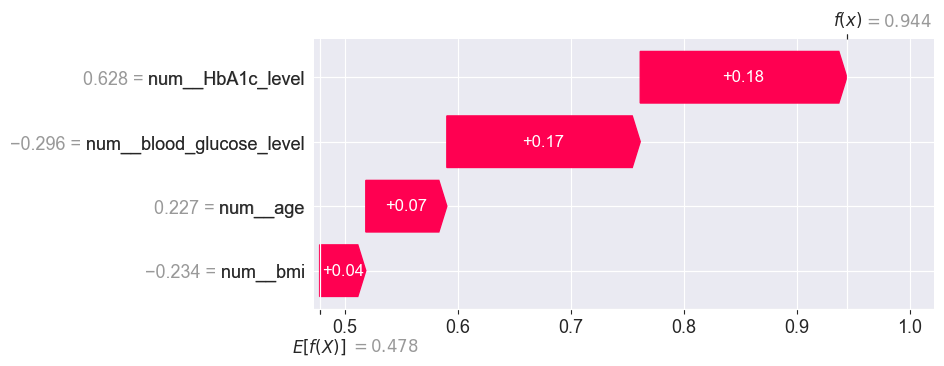

In [99]:
shap.plots.waterfall(shap_values[0][:, 0])

In [117]:
single_shap = shap_values[0]
print(single_shap.values.shape)
print(single_shap.feature_names)

(4, 2)
['num__age', 'num__bmi', 'num__HbA1c_level', 'num__blood_glucose_level']


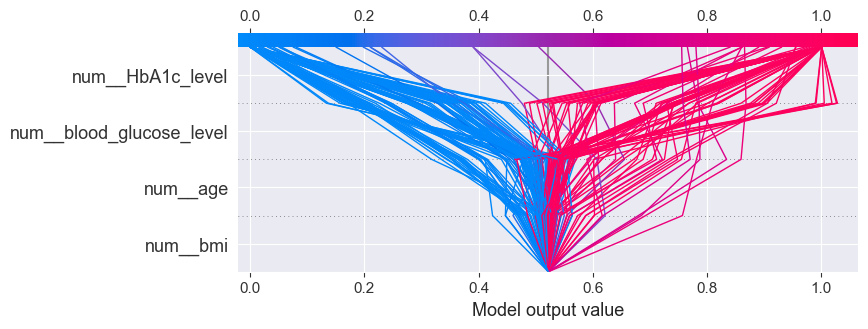

In [121]:
shap.decision_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_values.values[:, :, 1],
    features=X_test_sel_df.iloc[:10],
    feature_names=shap_values.feature_names
)

In [123]:
# 15. LIME explanation
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_sel,
    feature_names=feature_names,
    class_names=["No Diabetes", "Diabetes"],
    mode="classification"
)

sample_idx = 10
lime_exp = lime_explainer.explain_instance(
    X_test_sel[sample_idx],
    rf.predict_proba,
    num_features=10
)
with open("lime_explanation.html", "w", encoding="utf-8") as f:
    f.write(lime_exp.as_html())

In [124]:
joblib.dump(rf, "rf_diabetes_smote_model.pkl")
joblib.dump(logreg, "logreg_diabetes_model.pkl")

['logreg_diabetes_model.pkl']